# 수정사항

- GPU 사용
- FOLD별 모델 별도 저장 -> 이후 앙상블을 위한 처리
- Feature Importance 시각화

# 모듈 임포트

In [1]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import  GroupKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from lightgbm import log_evaluation, early_stopping

tqdm.pandas()

# 데이터 준비

In [2]:
train_idf = pd.read_csv("data/train_identity.csv")
train_trans = pd.read_csv("data/train_transaction.csv")
test_idf = pd.read_csv("data/test_identity.csv")
test_trans = pd.read_csv("data/test_transaction.csv")

test_trans["isFraud"] = -1

train_trans = train_trans.merge(train_idf, on="TransactionID", how="left")
test_trans = test_trans.merge(train_idf, on="TransactionID", how="left")

train_trans["type"] = "train"
test_trans["type"] = "test"

df = pd.concat([train_trans, test_trans], axis=0)

start_date = datetime.datetime.strptime("2017.12.01", "%Y.%m.%d") # 시작일 설정
df["time"] = df["TransactionDT"].apply(
    lambda x: datetime.timedelta(seconds=x) + start_date
)
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['DT_M'] = (df['year']-2017)*12 + df['month']

del train_trans, test_trans

# Count Encoding

In [3]:
cat_cols = ["ProductCD", "card1"]
for col in cat_cols:
    df[col + "_ce"] = df[col].map(df[col].value_counts(dropna=False))

In [4]:
# ProductCD별로 TransactionAmt의 평균값과 표준편차를 구해 ex에 담음
ex = df.groupby("ProductCD").agg({"TransactionAmt" : ["mean", "std"]})
ex.reset_index(inplace=True)
ex.columns = ["ProductCD", "ProductCD_Amt_mean", "ProductCD_Amt_std"]

# 기존 데이터의 ProductCD를 기준으로 join
df = df.merge(ex, on="ProductCD", how="left")

In [5]:
# Account Start date를 만드는 함수 생성
def account_start_date(val):
    if np.isnan(val):
        return np.NaN
    else:
        days = int(str(val).split(".")[0])
        return pd.Timedelta(str(days) + " days")

# Account_make_Date 변수 생성
for i in ["D1", "D2", "D4", "D8", "D10", "D15"]:
    df["account_start_day"] = df[i].apply(account_start_date)
    df["account_make_date"] = (df["time"] - df["account_start_day"]).dt.date
    df["account_make_date_{}".format(i)] = (
        (10000 * pd.to_datetime(df["account_make_date"]).dt.year)
        + (100 * pd.to_datetime(df["account_make_date"]).dt.month)
        + (1 * pd.to_datetime(df["account_make_date"]).dt.day)
    )

ex = (
    df.groupby(["card1", "account_make_date_D1", "ProductCD"])
    .agg({"TransactionAmt" : ["mean", "std"]})
    .reset_index()
)

ex.columns = [
    "card1",
    "account_make_date_D1",
    "ProductCD",
    "D1_card_Product_mean",
    "D1_card_Product_std",
]

df = df.merge(ex, on=["card1", "account_make_date_D1", "ProductCD"], how="left")
del df["time"]

In [6]:
df["device_prev_trans"] = df["TransactionDT"] - df.groupby(["id_30", "id_31", "id_33", "DeviceType", "DeviceInfo"])["TransactionDT"].shift(1)
df["device_after_trans"] = df["TransactionDT"] - df.groupby(["id_30", "id_31", "id_33", "DeviceType", "DeviceInfo"])["TransactionDT"].shift(-1)

In [7]:
train_df = df.loc[df.isFraud != -1].copy()
test_df = df.loc[df.isFraud == -1].copy()

# Label Encoding

In [8]:
for col in tqdm(train_df.columns):
    if train_df[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(train_df[col].astype(str).values) + list(test_df[col].astype(str).values))
        train_df[col] = le.transform(list(train_df[col].astype(str).values))
        test_df[col] = le.transform(list(test_df[col].astype(str).values))

  0%|          | 0/454 [00:00<?, ?it/s]

# Feature

In [9]:
features = [c for c in train_df.columns if c not in ['TransactionID', 'isFraud','TransactionDT','timeblock','account_start_day', 'date'
                                                    , 'year', 'month', 'target', 'day','account_make_date_D11', 'account_make_date_D3', 'account_make_date_D5', 'account_make_date_D4' , 'account_make_date_D8', 'account_make_date_D14', 'account_make_date_D6', 'account_make_date_D12', 'account_make_date_D7'
                                                    , 'card_1_2_3_5_nunique', 'card_1_2_3_5_prev_click', 'card_1_2_3_5_next_click', 'card_1_3_TransactionAmt_prev_click', 'card_1_3_TransactionAmt_next_click', 'account_make_date'
                                                    , 'poten_card1_nunique_D5', 'poten_card1_nunique_D11','poten_card1_nunique_D6', 'poten_card1_nunique_D3','poten_card1_nunique_D7','poten_card1_nunique_D12','poten_card1_nunique_D8','poten_card1_nunique_D4','poten_card1_nunique_D14'
                                                    , 'id_13', 'id_31', 'id_13_count_full', 'id_31_count_full','ProductCD', 'card3', 'card4', 'card5', 'card6', 'M1', 'M2', 'M3',
       'M4', 'M5', 'M7', 'M8', 'M9', 'P_emaildomain_bin',
       'P_emaildomain_suffix', 'R_emaildomain_bin',
       'R_emaildomain_suffix', 'account_make_date',
       'account_make_date_D3', 'account_make_date_D4',
       'account_make_date_D7', 'account_make_date_D8',
       'account_make_date_D11', 'account_make_date_D12',
       'account_make_date_D14', 'dayofweek', 'hour', 'card1_addr1',
       'card1_ProductCD', 'count_x', 'count_y', 'D15', "card1_TransactionAmt_mean",
        'card1_addr1hourstd','card1_addr1hourmedian','uid_hour_std','uid2_hour_std','card1_ProductCD_hour_std','card1_addr2_hour_std',
        'card1_TransactionAmt_nunique','card2_TransactionAmt_nunique','card3_TransactionAmt_nunique','card5_TransactionAmt_nunique','uid_TransactionAmt_nunique',
        'uid_hour_nunique','uid2_hour_nunique','card1_addr2_hour_nunique','card1_ProductCD_hour_nunique','account_make_date_D1','card1_year_month_mean','uid2_D4_mean','uid2_dayofweek_std','DT_M','Transactionhourcount','account_make_date_D1_card1','account_make_date_D2']]

In [10]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47,
           # GPU 사용 
          'device_type': 'gpu',  # CPU를 사용할 경우 'cpu'
          'gpu_platform_id': 0,  # GPU 플랫폼 ID
          'gpu_device_id': 0,   # GPU 디바이스 ID
         }

# Train

In [12]:
import warnings
warnings.filterwarnings('always')  # 모든 warning 표시

In [13]:
NFOLD = 6
folds = GroupKFold(n_splits=NFOLD)

X = train_df[features]
y = train_df["isFraud"]
test = test_df[features]

split_groups = train_df["DT_M"] # 월 단위를 그룹으로 선정

aucs = list() # validation auc 점수를 저장
feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns
oofs = np.zeros(len(train_df))
preds = np.zeros(len(test))

for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y, groups=split_groups)):
    print(f"Training on fold {fold + 1}")

    trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])
    
    # 콜백 함수 설정
    callbacks = [
        log_evaluation(period=500),
        early_stopping(stopping_rounds=100)
    ]
    clf = lgb.train(
        params,
        trn_data,
        10000,
        valid_sets=[trn_data, val_data],
        callbacks=callbacks,
    )
    oofs[test_idx] = clf.predict(X.iloc[test_idx])
    preds += clf.predict(test) / NFOLD

    feature_importances[f"fold_{fold + 1}"] = clf.feature_importance()
    aucs.append(clf.best_score["valid_1"]["auc"])

    joblib.dump(clf, f'model/lgbm_fold_{fold + 1}.pkl')

print("-" * 30)
print("Mean AUC : ", np.mean(aucs))
print("Total Validation : ", roc_auc_score(y, oofs))
print("-" * 30)

Training on fold 1
Training until validation scores don't improve for 100 rounds
[500]	training's auc: 0.983193	valid_1's auc: 0.900202
[1000]	training's auc: 0.996706	valid_1's auc: 0.911008
[1500]	training's auc: 0.999318	valid_1's auc: 0.912653
Early stopping, best iteration is:
[1483]	training's auc: 0.999282	valid_1's auc: 0.912712
Training on fold 2
Training until validation scores don't improve for 100 rounds
[500]	training's auc: 0.982448	valid_1's auc: 0.933321
[1000]	training's auc: 0.996756	valid_1's auc: 0.942091
Early stopping, best iteration is:
[1197]	training's auc: 0.99833	valid_1's auc: 0.942777
Training on fold 3
Training until validation scores don't improve for 100 rounds
[500]	training's auc: 0.980951	valid_1's auc: 0.932018
[1000]	training's auc: 0.996287	valid_1's auc: 0.944531
[1500]	training's auc: 0.999217	valid_1's auc: 0.947062
Early stopping, best iteration is:
[1595]	training's auc: 0.999403	valid_1's auc: 0.947266
Training on fold 4
Training until valida

- gpu 사용 학습 : 51분 37초
    - Mean AUC : 0.9420401586679713

- GPU 사용 결과 학습 시간이 크게 개선되지는 않았습니다. (약 5분)
- lgbm은 알고리즘 구현상 catboost, xgboost에 비해 gpu 연산을 적게 사용합니다.

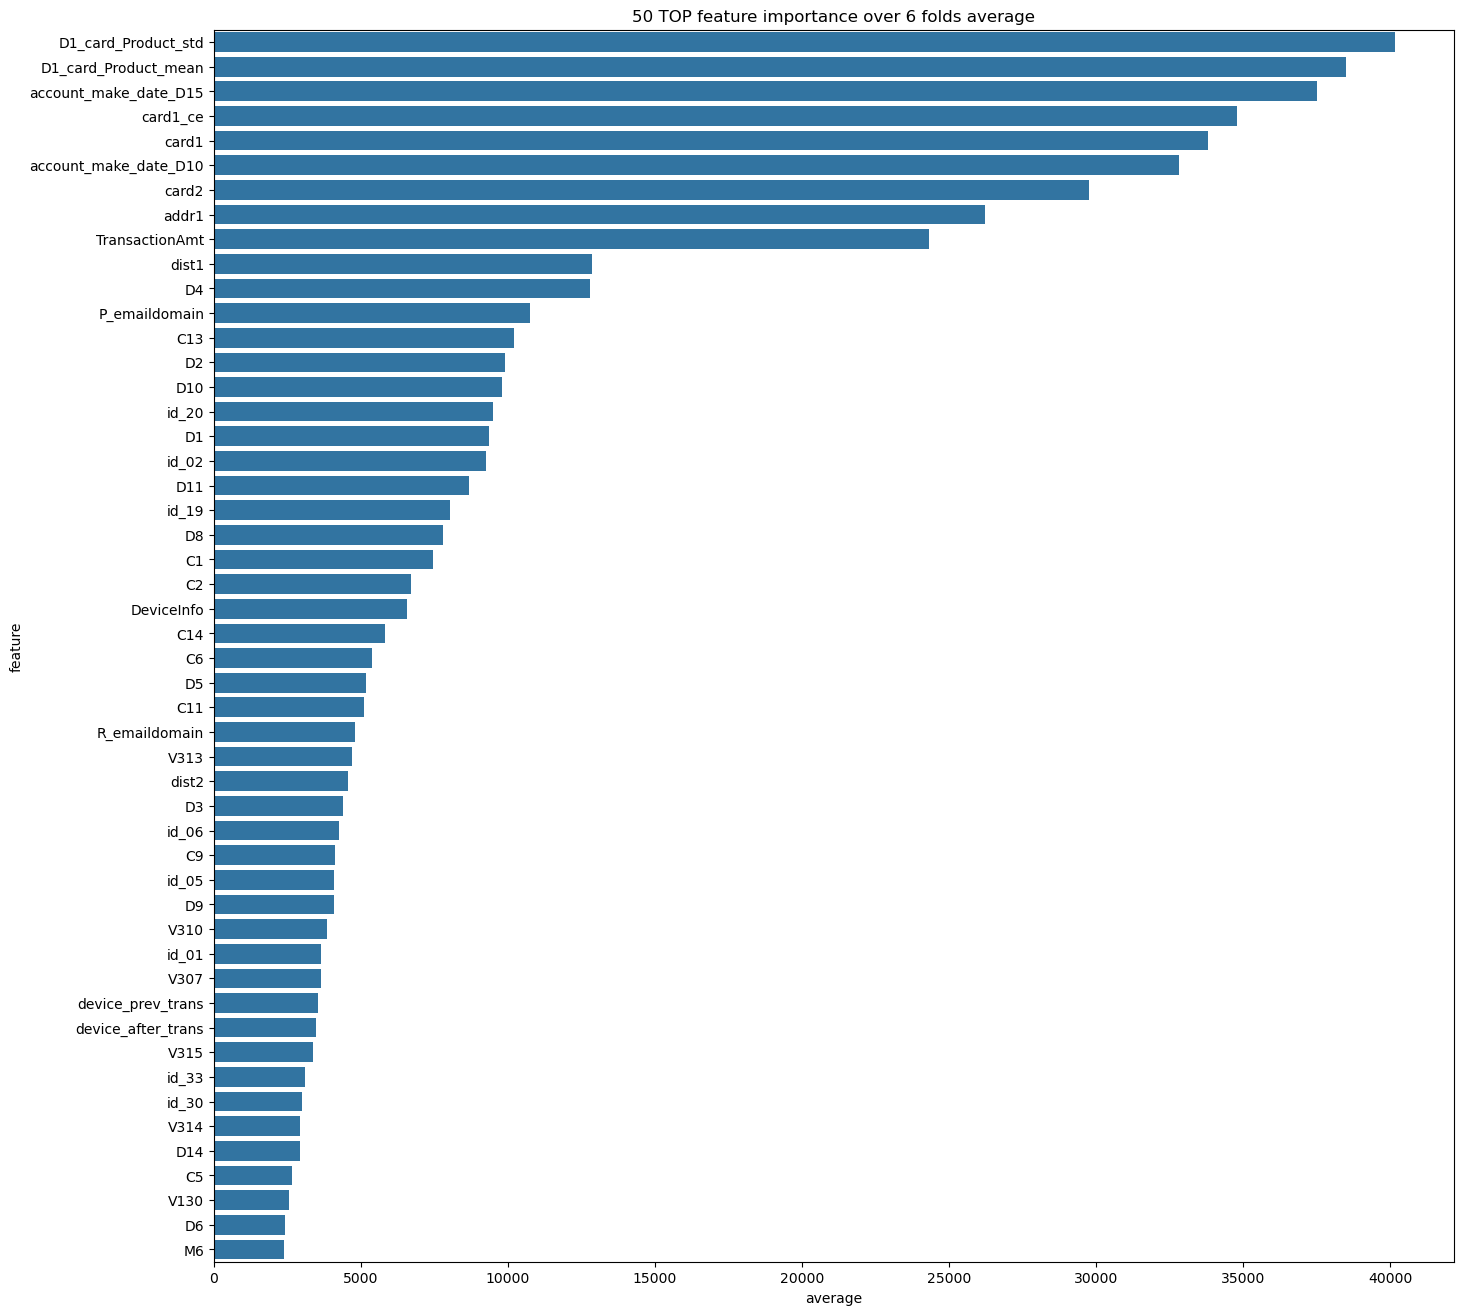

In [14]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));